In [77]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss, brier_score_loss
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
!pip install shap
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable


In [79]:
# 1) Load dataset (update path if needed)
# -------------------------
# Expected columns (based on your screenshot): 
# 'Div','Date','Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR',
# 'HTHG','HTAG','HTR','Referee','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY', ...
df = pd.read_csv("matches.csv", parse_dates=["Date"], dayfirst=True)  # or pd.read_excel("matches.xlsx")
print("Loaded:", df.shape)
display(df.head())


Loaded: (380, 106)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,...,1.84,0.75,2.01,1.89,2.02,1.91,2.13,1.92,2.02,1.87
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,...,1.70,0.25,1.78,2.13,1.79,2.17,1.85,2.18,1.79,2.12
2,E0,2020-09-12,17:30,Liverpool,Leeds,4,3,H,3,2,...,2.62,-1.50,1.85,2.05,1.85,2.08,1.90,2.16,1.84,2.04
3,E0,2020-09-12,20:00,West Ham,Newcastle,0,2,A,0,0,...,1.92,-0.50,2.03,1.87,2.04,1.88,2.09,1.91,2.02,1.86
4,E0,2020-09-13,14:00,West Brom,Leicester,0,3,A,0,0,...,1.73,0.25,1.92,1.98,1.93,1.99,1.95,2.01,1.91,1.97


In [81]:
# 2) Basic cleaning & sanity checks
# -------------------------
# drop duplicates / NA rows in essential cols
df = df.dropna(subset=["Date","HomeTeam","AwayTeam","FTR","FTHG","FTAG"]).copy()
# make sure Date is datetime
if df['Date'].dtype != 'datetime64[ns]':
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Filter obvious bad rows
df = df[~df['Date'].isna()]

# Sort by date (important for time-based splitting)
df = df.sort_values("Date").reset_index(drop=True)

In [83]:
# 3) Target encoding
# -------------------------
# Map FTR: 'H'->0 (home win), 'D'->1 (draw), 'A'->2 (away win)
target_map = {'H':0, 'D':1, 'A':2}
df['target'] = df['FTR'].map(target_map)

In [85]:
# 4) Team-level rolling features (form, goals for/against, avg points, home/away form)
# -------------------------
# We'll compute for each team their rolling statistics over the last N matches prior to each match.
N = 5  # last N matches to use for rolling features

# Helper to get match result points per team for a match row
def get_team_rows(df):
    # create two-row-per-match frame with team, opponent, is_home, goals_for, goals_against, points, date, match_id
    rows = []
    for idx, r in df.iterrows():
        # home team row
        if r['FTHG'] is None or r['FTAG'] is None:
            continue
        gf = float(r['FTHG']); ga = float(r['FTAG'])
        if r['FTR'] == 'H':
            pts_home, pts_away = 3, 0
        elif r['FTR'] == 'D':
            pts_home, pts_away = 1, 1
        else:
            pts_home, pts_away = 0, 3
        rows.append({
            'match_id': idx, 'team': r['HomeTeam'], 'opp': r['AwayTeam'],
            'is_home': 1, 'gf': gf, 'ga': ga, 'points': pts_home, 'date': r['Date']
        })
        rows.append({
            'match_id': idx, 'team': r['AwayTeam'], 'opp': r['HomeTeam'],
            'is_home': 0, 'gf': ga, 'ga': gf, 'points': pts_away, 'date': r['Date']
        })
    team_df = pd.DataFrame(rows)
    return team_df

team_df = get_team_rows(df)

# Sort by team/date
team_df = team_df.sort_values(['team','date']).reset_index(drop=True)

# Compute rolling stats per team
team_df['roll_gf_mean'] = team_df.groupby('team')['gf'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())
team_df['roll_ga_mean'] = team_df.groupby('team')['ga'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())
team_df['roll_points_sum'] = team_df.groupby('team')['points'].transform(lambda x: x.shift().rolling(N, min_periods=1).sum())
team_df['roll_form_strength'] = team_df.groupby('team')['points'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())  # average points

# For home/away splits: last N home matches gf/ga and away matches
team_df['roll_home_gf'] = team_df[team_df['is_home']==1].groupby('team')['gf'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())
team_df['roll_away_gf'] = team_df[team_df['is_home']==0].groupby('team')['gf'].transform(lambda x: x.shift().rolling(N, min_periods=1).mean())
# (Above lines introduce NaNs where subset doesn't match; we'll merge carefully)

# Merge features back to original matches (home and away)
# For merge, keep only latest row per match+team pair by match_id and team
home_feats = team_df[team_df['is_home']==1].set_index('match_id')[['team','roll_gf_mean','roll_ga_mean','roll_points_sum','roll_form_strength','roll_home_gf','roll_away_gf']]
away_feats = team_df[team_df['is_home']==0].set_index('match_id')[['team','roll_gf_mean','roll_ga_mean','roll_points_sum','roll_form_strength','roll_home_gf','roll_away_gf']]

# rename columns so they are distinct
home_feats = home_feats.add_prefix('home_')
away_feats = away_feats.add_prefix('away_')

# combine into df by match_id index
df = df.reset_index().rename(columns={'index':'match_id'})
df = df.set_index('match_id').join(home_feats, how='left').join(away_feats, how='left')
df = df.reset_index()

In [87]:
# 5) Head-to-head count (last M matches between these two teams)
# -------------------------
M = 6
# build a quick head-to-head engine
def compute_h2h_features(df, M=6):
    # create a key for unordered team pair
    df['pair'] = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
    # accumulate lists of previous results for pair
    h2h_dict = {}
    h2h_rows = []
    for idx, r in df.iterrows():
        pair = r['pair']
        prev = h2h_dict.get(pair, [])
        # compute features from prev
        last = prev[-M:] if len(prev)>0 else []
        # compute counts: home wins in h2h (when current home was home in those prev matches)
        # prev entries are tuples: (homeTeam, awayTeam, ftr)
        home_team = r['HomeTeam']; away_team = r['AwayTeam']
        # compute last matches where these exact teams faced; convert to perspective of current home team
        home_wins = sum(1 for p in last if (p[2]=='H' and p[0]==home_team) or (p[2]=='A' and p[1]==home_team))
        away_wins = sum(1 for p in last if (p[2]=='A' and p[1]==away_team) or (p[2]=='H' and p[0]==away_team))
        draws = sum(1 for p in last if p[2]=='D')
        h2h_rows.append({'match_id': idx, 'h2h_home_wins': home_wins, 'h2h_away_wins': away_wins, 'h2h_draws': draws, 'h2h_total': len(last)})
        # append current match to dict
        if pair not in h2h_dict: h2h_dict[pair] = []
        h2h_dict[pair].append((r['HomeTeam'], r['AwayTeam'], r['FTR']))
    h2h_df = pd.DataFrame(h2h_rows).set_index('match_id')
    return h2h_df

h2h_df = compute_h2h_features(df, M=6)
df = df.set_index('match_id').join(h2h_df).reset_index()

In [89]:
# 6) Simple Elo rating (team strength)
# -------------------------
# initialize elo dictionary with same starting rating
K = 20
START_ELO = 1500
teams = pd.unique(df[['HomeTeam','AwayTeam']].values.ravel('K'))
elo = {t: START_ELO for t in teams}
elo_history = []

def expected(a, b):
    return 1.0 / (1 + 10 ** ((b - a) / 400.0))

for idx, r in df.iterrows():
    ht, at = r['HomeTeam'], r['AwayTeam']
    # store current elos as features
    df.loc[idx, 'elo_home_pre'] = elo[ht]
    df.loc[idx, 'elo_away_pre'] = elo[at]
    # result to score (home perspective)
    if r['FTR']=='H':
        s_home, s_away = 1.0, 0.0
    elif r['FTR']=='D':
        s_home, s_away = 0.5, 0.5
    else:
        s_home, s_away = 0.0, 1.0
    # expected
    e_home = expected(elo[ht], elo[at])
    e_away = expected(elo[at], elo[ht])
    # update elo
    elo[ht] = elo[ht] + K * (s_home - e_home)
    elo[at] = elo[at] + K * (s_away - e_away)

In [91]:
# 7) Other features
# -------------------------
# home advantage: simple binary
df['is_played_home'] = 1
# goal difference in recent N matches (home - away recent)
df['home_recent_gf'] = df['home_roll_gf_mean'] = df.get('home_roll_gf', df.get('home_roll_gf', np.nan))
# create goal diff of teams over last N matches
df['home_goal_diff_recent'] = df['home_roll_gf_mean'] - df['home_roll_ga_mean']
df['away_goal_diff_recent'] = df['away_roll_gf_mean'] - df['away_roll_ga_mean']

# Create simple features from match-level stats if present
possibly_present = ['HS','AS','HST','AST','HC','AC','HF','AF','HY','AY']
for c in possibly_present:
    if c in df.columns:
        df[f'{c}'] = pd.to_numeric(df[c], errors='coerce')
    else:
        df[c] = np.nan

# days since last match for each team (fatigue)
df['days_since_home_last'] = np.nan
df['days_since_away_last'] = np.nan
last_date = {}
for idx, r in df.iterrows():
    ht, at, date = r['HomeTeam'], r['AwayTeam'], r['Date']
    # home
    if ht in last_date:
        df.loc[idx, 'days_since_home_last'] = (date - last_date[ht]).days
    else:
        df.loc[idx, 'days_since_home_last'] = np.nan
    last_date[ht] = date
    # away
    if at in last_date:
        df.loc[idx, 'days_since_away_last'] = (date - last_date[at]).days
    else:
        df.loc[idx, 'days_since_away_last'] = np.nan
    last_date[at] = date

In [93]:
# 8) Final feature selection
# -------------------------
# choose a set of features (tweak/expand as you see fit)
features = [
    'elo_home_pre','elo_away_pre',
    'home_roll_gf_mean','home_roll_ga_mean','home_roll_points_sum',
    'away_roll_gf_mean','away_roll_ga_mean','away_roll_points_sum',
    'h2h_home_wins','h2h_away_wins','h2h_draws','h2h_total',
    'home_goal_diff_recent','away_goal_diff_recent',
    'days_since_home_last','days_since_away_last',
    'HS','AS','HST','AST','HC','AC'
]

# Ensure features exist in dataframe; fill missing with zeros or means
for f in features:
    if f not in df.columns:
        df[f] = np.nan
df[features] = df[features].astype(float)
df[features] = df[features].fillna(0.0)

X = df[features]
y = df['target']

In [95]:
# 9) Time-based train/test split (never leak future)
# -------------------------
# We'll use the last 15% of matches as test (time-based)
dates = df['Date'].sort_values()
split_date = dates.iloc[int(0.85 * len(dates))]
train_idx = df['Date'] <= split_date
test_idx = df['Date'] > split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train/Test sizes:", X_train.shape, X_test.shape)

Train/Test sizes: (324, 22) (56, 22)


In [97]:
# 10) Baseline scaling + Logistic Regression
# -------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
y_proba_lr = lr.predict_proba(X_test_s)

print("Logistic Regression accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression f1 (macro):", f1_score(y_test, y_pred_lr, average='macro'))
print("Logistic Regression log_loss:", log_loss(y_test, y_proba_lr))

Logistic Regression accuracy: 0.6607142857142857
Logistic Regression f1 (macro): 0.5363247863247863
Logistic Regression log_loss: 0.8477112820416904


In [99]:
# 11) XGBoost (stronger model)
# -------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective':'multi:softprob',
    'num_class':3,
    'eval_metric':'mlogloss',
    'eta':0.05,
    'max_depth':6,
    'subsample':0.8,
    'colsample_bytree':0.7,
    'seed':42,
}

evallist = [(dtrain, 'train'), (dtest, 'eval')]

bst = xgb.train(params, dtrain, num_boost_round=500, evals=evallist, early_stopping_rounds=20, verbose_eval=50)

y_proba_xgb = bst.predict(dtest)
y_pred_xgb = np.argmax(y_proba_xgb, axis=1)

print("XGB accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGB f1 (macro):", f1_score(y_test, y_pred_xgb, average='macro'))
print("XGB log_loss:", log_loss(y_test, y_proba_xgb))

# Save models & scaler
joblib.dump(scaler, "scaler.joblib")
joblib.dump(lr, "logreg_model.joblib")
bst.save_model("xgb_model.json")

[0]	train-mlogloss:1.06861	eval-mlogloss:1.08743
[50]	train-mlogloss:0.39357	eval-mlogloss:0.94535
[59]	train-mlogloss:0.34325	eval-mlogloss:0.94834
XGB accuracy: 0.5892857142857143
XGB f1 (macro): 0.48407029478458047
XGB log_loss: 0.9480180099829754


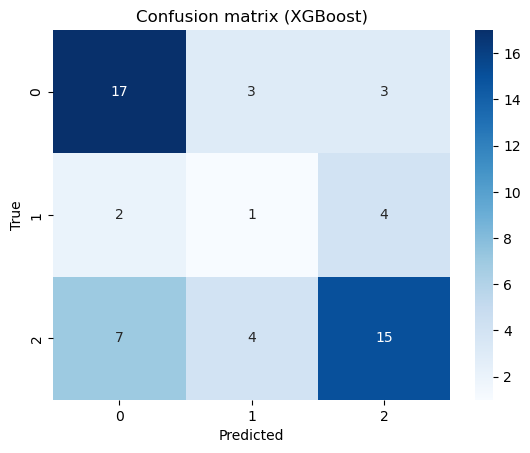

Brier score for Home: 0.1812
Brier score for Draw: 0.1411
Brier score for Away: 0.2324


In [101]:
# 12) Evaluation: confusion matrix, calibration, reliability
# -------------------------
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# class-prob calibration: Brier score per class
for i, cls in enumerate(['Home','Draw','Away']):
    if y_proba_xgb.shape[0] > 0:
        brier = brier_score_loss((y_test==i).astype(int), y_proba_xgb[:,i])
        print(f'Brier score for {cls}: {brier:.4f}')

In [103]:
# In notebook
!pip install shap --upgrade


Defaulting to user installation because normal site-packages is not writeable


SHAP found — computing SHAP values (sampling to speed up).


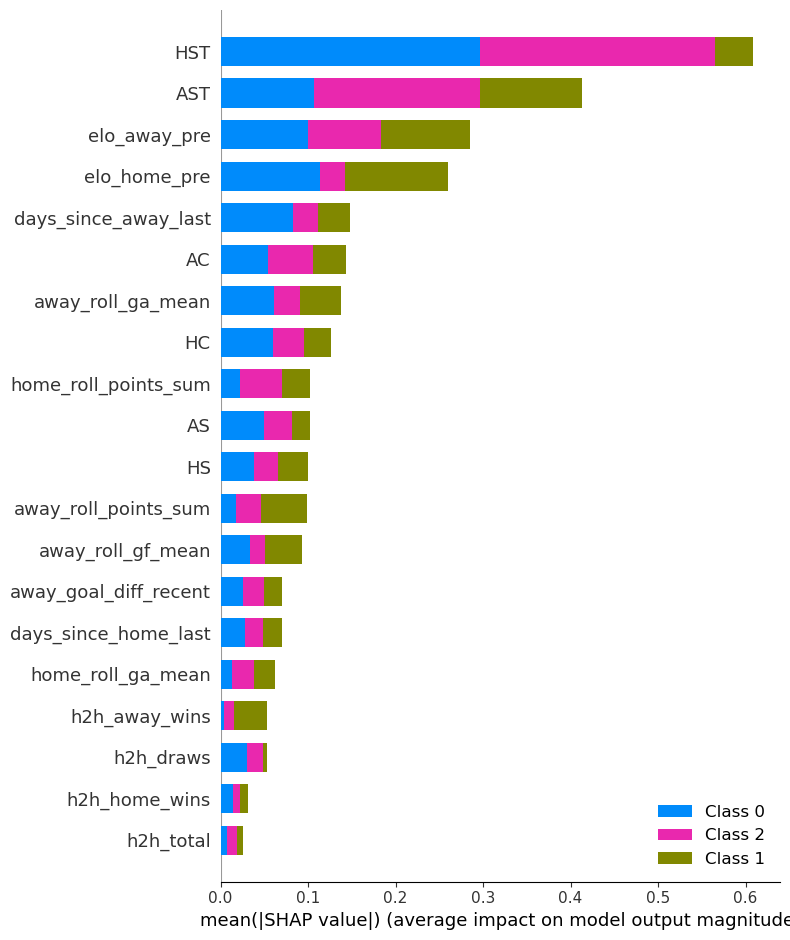

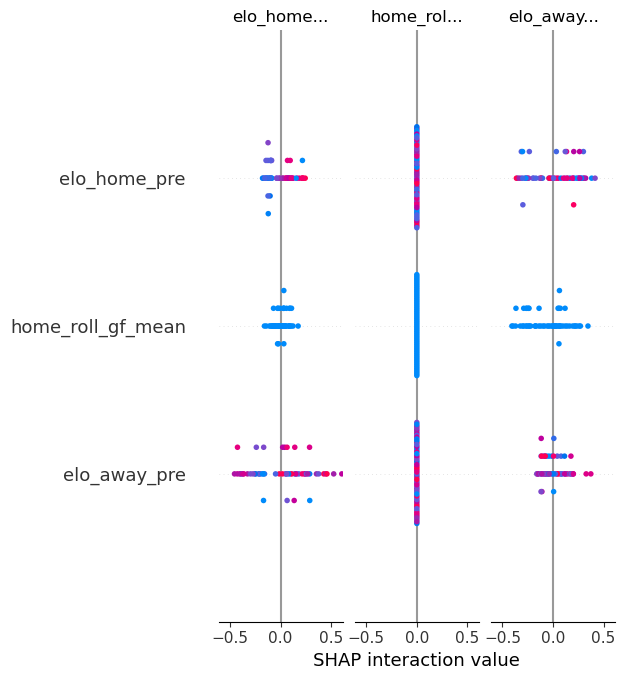

SHAP failed or not installed: NotImplementedError matplotlib = True is not yet supported for force plots with multiple samples!
Falling back to XGBoost built-in importance, permutation importance, and partial-dependence plots.


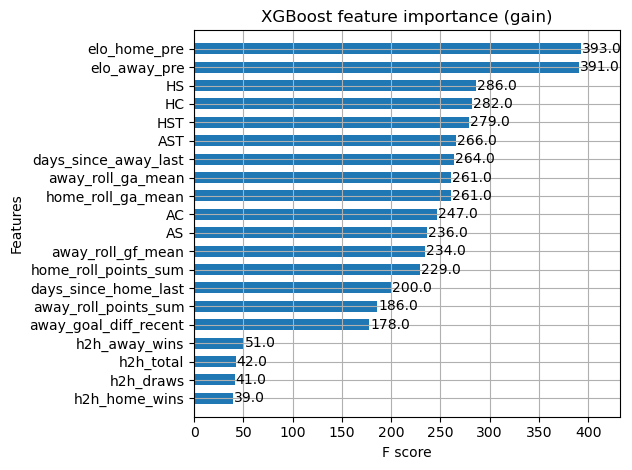

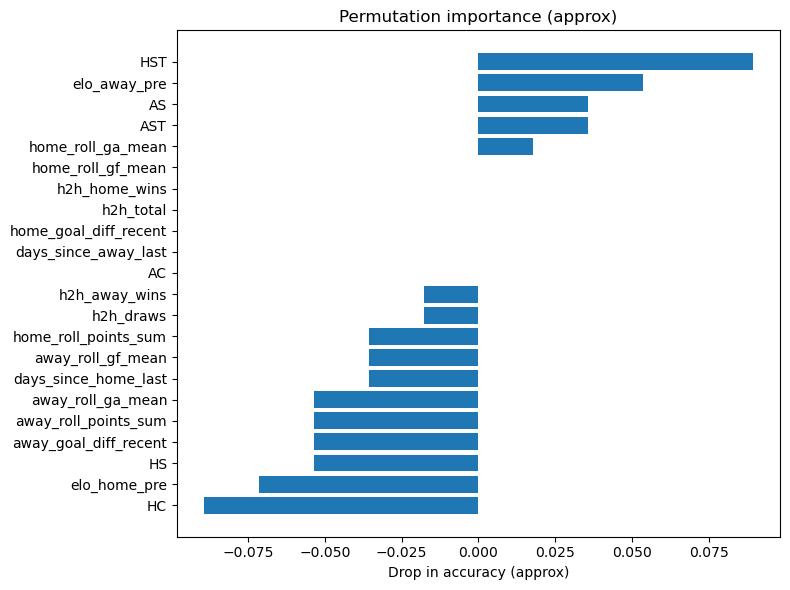

Permutation importance saved.
Partial dependence plotting failed: The 'estimator' parameter of partial_dependence must be an object implementing 'fit' and 'predict', an object implementing 'fit' and 'predict_proba' or an object implementing 'fit' and 'decision_function'. Got <__main__.XGBSklearnWrapper object at 0x0000013B67CF4830> instead.
Explainability step completed — check explainability_plots


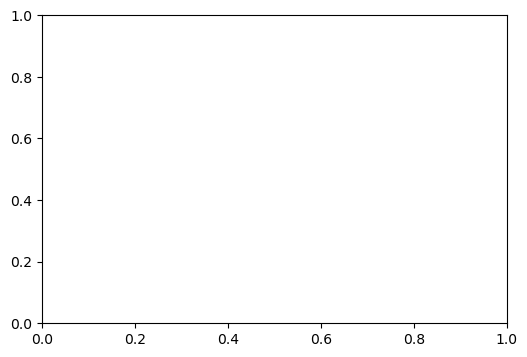

In [104]:
# ---------- Step 13+ : Explainability (SHAP if available, else fallback) ----------
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plots_dir = "explainability_plots"
os.makedirs(plots_dir, exist_ok=True)

try:
    import shap
    print("SHAP found — computing SHAP values (sampling to speed up).")
    # Use TreeExplainer for XGBoost trees
    explainer = shap.TreeExplainer(bst)
    # sample test rows (SHAP can be slow)
    Xs = X_test.sample(min(200, len(X_test)), random_state=42)
    shap_vals = explainer.shap_values(Xs)  # for multi-class returns list-like per class
    # Global importance summary (bar)
    shap.summary_plot(shap_vals, Xs, plot_type="bar", show=True)
    plt.savefig(os.path.join(plots_dir, "shap_summary_bar.png"), bbox_inches="tight")
    plt.close()

    # SHAP summary (dot) — useful for slides
    shap.summary_plot(shap_vals, Xs, show=True)
    plt.savefig(os.path.join(plots_dir, "shap_summary_dot.png"), bbox_inches="tight")
    plt.close()

    # Single-match (force) plot for the first sampled row
    single_idx = Xs.index[0]
    x_row = Xs.loc[[single_idx]]
    # For tree models, explainer.expected_value is array-like per class
    shap_vals_row = explainer.shap_values(x_row)
    # Save force plot as matplotlib (static)
    shap.force_plot(explainer.expected_value[0], shap_vals_row[0], x_row, matplotlib=True, show=True)
    plt.savefig(os.path.join(plots_dir, f"shap_force_row_{single_idx}.png"), bbox_inches="tight")
    plt.close()

    # SHAP dependence plot for top feature (find top feature by mean abs shap)
    # for multiclass, consider class 0 (home) or aggregate by sum(abs)
    mean_abs = np.abs(np.vstack([np.abs(s).mean(axis=0) for s in shap_vals])).sum(axis=0)
    top_idx = int(np.argmax(mean_abs))
    top_feature = Xs.columns[top_idx]
    print("Top feature for dependence:", top_feature)
    shap.dependence_plot(top_feature, shap_vals, Xs, show=True)
    plt.savefig(os.path.join(plots_dir, f"shap_dependence_{top_feature}.png"), bbox_inches="tight")
    plt.close()

    print("SHAP plots saved in", plots_dir)

except Exception as e:
    print("SHAP failed or not installed:", type(e).__name__, e)
    print("Falling back to XGBoost built-in importance, permutation importance, and partial-dependence plots.")

    # 1) XGBoost built-in importance
    try:
        ax = xgb.plot_importance(bst, max_num_features=25, height=0.6)
        plt.title("XGBoost feature importance (gain)")
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "xgb_importance_gain.png"), bbox_inches="tight")
        plt.show()
        plt.close()
    except Exception as ex:
        print("Could not plot xgb importance:", ex)

    # 2) Manual permutation importance (approx) — measures drop in accuracy
    try:
        base_preds = np.argmax(bst.predict(xgb.DMatrix(X_test)), axis=1)
        base_acc = (base_preds == y_test).mean()
        perm_imp = {}
        rng = np.random.RandomState(42)
        cols = list(X_test.columns)
        # run on a sample to speed up
        sample_idx = X_test.sample(min(300, len(X_test)), random_state=42).index
        X_sample = X_test.loc[sample_idx].copy()
        y_sample = y_test.loc[sample_idx]
        for col in cols:
            Xp = X_sample.copy()
            Xp[col] = rng.permutation(Xp[col].values)
            perm_preds = np.argmax(bst.predict(xgb.DMatrix(Xp)), axis=1)
            perm_acc = (perm_preds == y_sample).mean()
            perm_imp[col] = base_acc - perm_acc
        # sort by importance
        imp_sorted = sorted(perm_imp.items(), key=lambda x: x[1], reverse=True)[:25]
        feat_names = [k for k,_ in imp_sorted]
        imp_vals = [v for _,v in imp_sorted]

        plt.figure(figsize=(8,6))
        plt.barh(feat_names[::-1], imp_vals[::-1])
        plt.xlabel("Drop in accuracy (approx)")
        plt.title("Permutation importance (approx)")
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "perm_importance.png"), bbox_inches="tight")
        plt.show()
        plt.close()
        print("Permutation importance saved.")
    except Exception as ex:
        print("Permutation importance failed:", ex)

    # 3) Partial Dependence (sklearn) for 1-2 top features (if sklearn available)
    try:
        from sklearn.inspection import PartialDependenceDisplay
        # choose top 2 features found above or by xgboost importance
        top2 = feat_names[:2] if 'feat_names' in locals() and len(feat_names)>0 else X_test.columns[:2].tolist()
        # Partial dependence requires an estimator with predict method that returns class predictions or probabilities.
        # We'll create a wrapper sklearn-like estimator using xgboost API for predicted probability of class 0 (home).
        class XGBSklearnWrapper:
            def __init__(self, booster, target_class=0):
                self.booster = booster
                self.target_class = target_class
            def predict(self, X):
                # return probability of target_class
                d = xgb.DMatrix(X)
                proba = self.booster.predict(d)
                # For multi-class get column of interest
                return proba[:, self.target_class]
        wrapper = XGBSklearnWrapper(bst, target_class=0)
        # plot partial dependence (for each feature)
        for feature in top2:
            fig, ax = plt.subplots(figsize=(6,4))
            # sklearn's PartialDependenceDisplay.from_estimator expects sklearn estimator — but accepts any with predict
            PartialDependenceDisplay.from_estimator(wrapper, X_test, [feature], ax=ax, kind='average')
            plt.title(f"Partial dependence (approx) for {feature} (class=Home prob)")
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f"pdp_{feature}.png"), bbox_inches="tight")
            plt.show()
            plt.close()
        print("Partial dependence plots saved.")
    except Exception as ex:
        print("Partial dependence plotting failed:", ex)

print("Explainability step completed — check", plots_dir)


In [107]:
import joblib
bst.save_model("xgb_model.json")
joblib.dump(scaler, "scaler.joblib")      # if scaler exists
joblib.dump(lr, "logreg_model.joblib")    # if logistic exists


['logreg_model.joblib']

In [110]:
import os
os.getcwd()


'C:\\Users\\Hp 840 G6'

In [112]:
import joblib, os, numpy as np, pandas as pd

model_path = r"C:\Users\Hp 840 G6\logreg_model.joblib"
print("Loading model from:", model_path)
model = joblib.load(model_path)
print("Loaded model type:", type(model))
print("model.classes_:", getattr(model, "classes_", None))
print("Has coef_?", hasattr(model, "coef_"))
if hasattr(model, "coef_"):
    print("coef_ shape:", model.coef_.shape)
    # show first 10 coeffs of first class
    print("coef_[0][:10]:", model.coef_[0][:10])
print("intercept_:", getattr(model, "intercept_", None))
# If model saved expected feature names:
print("feature_names_in_ (if present):", getattr(model, "feature_names_in_", None))


Loading model from: C:\Users\Hp 840 G6\logreg_model.joblib
Loaded model type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
model.classes_: [0 1 2]
Has coef_? True
coef_ shape: (3, 22)
coef_[0][:10]: [ 0.14356813 -0.22681447  0.         -0.22937978 -0.0847765  -0.16548817
  0.0557746   0.08912278  0.03259611 -0.01724508]
intercept_: [ 0.02992049 -0.14772773  0.11780724]
feature_names_in_ (if present): None


In [114]:
scaler_path = r"C:\Users\Hp 840 G6\scaler.joblib"
scaler = None
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    print("Loaded scaler from:", scaler_path)
    # print a short summary
    if hasattr(scaler, "mean_"):
        print("scaler.mean_ (first 10):", np.round(scaler.mean_[:10],4))
    if hasattr(scaler, "scale_"):
        print("scaler.scale_ (first 10):", np.round(scaler.scale_[:10],4))
else:
    print("No scaler found at", scaler_path)


Loaded scaler from: C:\Users\Hp 840 G6\scaler.joblib
scaler.mean_ (first 10): [1.5005194e+03 1.4998349e+03 0.0000000e+00 1.2886000e+00 6.2809000e+00
 1.2964000e+00 1.3228000e+00 6.2593000e+00 1.6670000e-01 1.5430000e-01]
scaler.scale_ (first 10): [44.1653 43.3157  1.      0.7361  3.557   0.7659  0.7355  3.5919  0.3727
  0.3613]


In [116]:
# Features list used when training (must match exactly)
features = [
 'elo_home_pre','elo_away_pre',
 'home_roll_gf_mean','home_roll_ga_mean','home_roll_points_sum',
 'away_roll_gf_mean','away_roll_ga_mean','away_roll_points_sum',
 'h2h_home_wins','h2h_away_wins','h2h_draws','h2h_total',
 'home_goal_diff_recent','away_goal_diff_recent',
 'days_since_home_last','days_since_away_last',
 'HS','AS','HST','AST','HC','AC'
]

# build two contrasting examples
home = {f:0.0 for f in features}
home.update({
    'elo_home_pre':1600,'elo_away_pre':1400,
    'HS':18,'AS':4,'HST':9,'AST':1,'HC':10,'AC':2
})

away = {f:0.0 for f in features}
away.update({
    'elo_home_pre':1400,'elo_away_pre':1600,
    'HS':4,'AS':18,'HST':1,'AST':9,'HC':2,'AC':10
})

Xtest = pd.DataFrame([home, away], columns=features).astype(float)
print("Xtest head:\n", Xtest.head())

# apply scaler if present
if scaler is not None:
    Xs = scaler.transform(Xtest)
    print("Applied scaler: Xs shape", Xs.shape)
else:
    Xs = Xtest.values
    print("No scaler - using raw values shape", Xs.shape)

# predict
probas = model.predict_proba(Xs)
preds = model.predict(Xs)

print("model.classes_:", model.classes_)
print("predict_proba rows:\n", np.round(probas,4))
print("predictions:", preds)


Xtest head:
    elo_home_pre  elo_away_pre  home_roll_gf_mean  home_roll_ga_mean  \
0        1600.0        1400.0                0.0                0.0   
1        1400.0        1600.0                0.0                0.0   

   home_roll_points_sum  away_roll_gf_mean  away_roll_ga_mean  \
0                   0.0                0.0                0.0   
1                   0.0                0.0                0.0   

   away_roll_points_sum  h2h_home_wins  h2h_away_wins  ...  \
0                   0.0            0.0            0.0  ...   
1                   0.0            0.0            0.0  ...   

   home_goal_diff_recent  away_goal_diff_recent  days_since_home_last  \
0                    0.0                    0.0                   0.0   
1                    0.0                    0.0                   0.0   

   days_since_away_last    HS    AS  HST  AST    HC    AC  
0                   0.0  18.0   4.0  9.0  1.0  10.0   2.0  
1                   0.0   4.0  18.0  1.0  9.0   2.

In [118]:
import joblib
import pandas as pd
import numpy as np

# --- Load model & scaler ---
model = joblib.load(r"C:\Users\Hp 840 G6\logreg_model.joblib")
scaler = joblib.load(r"C:\Users\Hp 840 G6\scaler.joblib")

# --- User Inputs (through input()) ---
print("Enter Match Stats:\n")

hs  = float(input("Home Shots (HS): "))
as_ = float(input("Away Shots (AS): "))
hst = float(input("Home Shots on Target (HST): "))
ast = float(input("Away Shots on Target (AST): "))
hc  = float(input("Home Corners (HC): "))
ac  = float(input("Away Corners (AC): "))

elo_home = float(input("Home Elo rating: "))
elo_away = float(input("Away Elo rating: "))

# --- FULL FEATURE LIST (22 features) ---
features = [
 'elo_home_pre','elo_away_pre',
 'home_roll_gf_mean','home_roll_ga_mean','home_roll_points_sum',
 'away_roll_gf_mean','away_roll_ga_mean','away_roll_points_sum',
 'h2h_home_wins','h2h_away_wins','h2h_draws','h2h_total',
 'home_goal_diff_recent','away_goal_diff_recent',
 'days_since_home_last','days_since_away_last',
 'HS','AS','HST','AST','HC','AC'
]

# --- Fill with defaults ---
vals = {f:0.0 for f in features}

# --- Update with user inputs ---
vals.update({
    'elo_home_pre': elo_home,
    'elo_away_pre': elo_away,
    'HS': hs,
    'AS': as_,
    'HST': hst,
    'AST': ast,
    'HC': hc,
    'AC': ac
})

# --- Create DataFrame in correct order ---
X = pd.DataFrame([vals], columns=features).astype(float)

# --- Apply scaler ---
Xs = scaler.transform(X)

# --- Predict probabilities ---
proba = model.predict_proba(Xs)[0]

classes = model.classes_

print("\nModel class order:", classes)
print("Raw probabilities:", proba)

# --- Map class id -> meaning ---
home_prob = proba[list(classes).index(0)]
draw_prob = proba[list(classes).index(1)]
away_prob = proba[list(classes).index(2)]

print("\n===== Prediction =====")
print(f"Home Win Probability: {home_prob*100:.2f}%")
print(f"Draw Probability:      {draw_prob*100:.2f}%")
print(f"Away Win Probability:  {away_prob*100:.2f}%")


Enter Match Stats:



Home Shots (HS):  4
Away Shots (AS):  13
Home Shots on Target (HST):  2
Away Shots on Target (AST):  5
Home Corners (HC):  2
Away Corners (AC):  1
Home Elo rating:  1300
Away Elo rating:  1500



Model class order: [0 1 2]
Raw probabilities: [0.12955666 0.106777   0.76366634]

===== Prediction =====
Home Win Probability: 12.96%
Draw Probability:      10.68%
Away Win Probability:  76.37%
